# Beyond Black and White: Adapting models to visual domain shift

### Authors: Chakradhar Rangi

The goal of this project is to demonstrate the need for and application of Domain Adaptation (DA) using the seemingly simple problem of handwritten digit classification. DA techniques allow neural networks trained on a **source domain** to generalize better to an unseen **target domain** without access to target labels. We are interested in a particular kind of domain shift, namely **covariate shift**. This occurs when the input probability distribution changes between the source (training) and target (deployment) domains, while the underlying classification task remains the same.

## Task 1: Demonstrate the Domain Shift Problem

The first task is to demonstrate the existence of covariate shift and its detrimental effect on the generalization capability of neural networks. To illustrate this effectively, we select a task that is fundamental to Deep Learning: the classification of handwritten digits.

We will build a Convolutional Neural Network (CNN) and train it on the **MNIST dataset** (source domain), which consists of grayscale images. Subsequently, we will evaluate the network's performance on the colored images of the **MNIST-M dataset** (target domain). While both datasets share the same label space and the underlying classification task is identical, the pixel distribution differs significantly, which we hypothesize will degrade model performance.



#### Dataset Description
* **Source domain dataset**: $\mathcal{D}_s = \{(X_s^{(i)}, Y_s^{(i)})\}_{i=1}^{N_s}$, where $X_s^{(i)} \sim P_s(X)$ are grayscale digit images from MNIST, and $Y_s^{(i)} \in \{0, ..., 9\}$ are the corresponding labels.
* **Target domain dataset**: $\mathcal{D}_t = \{X_t^{(j)}\}_{j=1}^{N_t}$, where $X_t^{(j)} \sim P_t(X)$ are images from MNIST-M. (Note: Target labels are available for evaluation but are assumed unknown during adaptation).

We assume the label distributions are aligned, i.e., $P_s(Y|X) = P_t(Y|X)$, but the input distributions differ: $P_s(X) \neq P_t(X)$.

#### Model Description

We define our CNN, $f_\theta$, with parameters $\theta$, which maps an input image $X \in \mathbb{R}^{C \times H \times W}$ to predicted class probabilities $\hat{Y} = f_\theta(X) \in \mathbb{R}^K$.

The network consists of two components:
1.  A **feature extractor** $\phi_\theta : \mathbb{R}^{n} \rightarrow \mathbb{R}^d$
2.  A **classifier head** $g_\theta : \mathbb{R}^d \rightarrow \mathbb{R}^K$ (where $K=10$)

The final output is given by:
$$f_\theta(X) = \text{softmax}(g_\theta(\phi_\theta(X)))$$

We define the **latent representation** $Z = \phi_\theta(X)$ as the output of the final hidden layer (before the classifier head). This latent vector will be the primary focus for our domain alignment strategies.

In [ ]:
# Checking if GPU from colab is available
!nvidia-smi

Fri Nov 28 03:55:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   33C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
# mount google drive to save and load files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the required libraries
import torch
from torch import nn, optim
from torch.autograd import Function
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request
import zipfile
import copy
import time
from tqdm import tqdm

# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Setting global variables
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
NUM_CLASSES = 10
NUM_WORKERS = 4

Using GPU: NVIDIA L4


### 1.1 Downloading and normalizing the datasets

MNIST is a very popular dataset in the world of deep learning and thus it is available through torchvision. However, the MNIST-M dataset is not available through torchvision. We will download the dataset from github which is freely available.

**Handling input data differences:** One of the obvious things to note is the difference in shape of input distribution. The MNIST dataset, being black and white, consists of single channel whereas, the MNIST-M dataset consists of three channels (RGB channels). To build a network which can handle both these different inputs, we shall create a three channel input to our network. We shall copy the single-channel image of MNIST across three-channels.  

**Note about normalization:** We will normalize the pixel values using a z-score normalization rather than conventional range of [0,1]. This method normalizes our data to have a mean of 0 and standard deviation of 1. The motivation to use the z-score stems from the vanishing gradient problem. Some activation functions like sigmoid, which have gradients maximum around zero will work better with z-score. Thus, we will adopt this method to transform both MNIST and MNIST-M. We refer online for the mean and standard deviation of pixel value distribution of MNIST data. For MNIST-M, we will do it manually.

#### 1.1.1 MNIST Download and normalization

In [3]:
# Mean and std of MNIST dataset
mnist_mean = (0.1307,) * 3  # Replicated for 3 channels
mnist_std = (0.3081,) * 3  # Replicated for 3 channels

# Define transform
mnist_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

# Downloading the MNIST dataset from torchvision
mnist_train = MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=mnist_transform)

# Split into Train (90%) and Validation (10%)
# Validation is used for model checkpointing/tuning
train_size = int(0.9 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_subset, val_subset = random_split(mnist_train, [train_size, val_size])

# Define DataLoaders
# pin_memory=True speeds up the transfer of data to the GPU
source_train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
source_val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
source_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.80MB/s]


#### 1.1.2 MNIST-M Download and normalization

In [4]:
# Downloading MNIST-M dataset from GitHub
# Setup paths
data_root = './data'
zip_name = 'MNIST-M.zip'
zip_path = os.path.join(data_root, zip_name)
url = "https://github.com/mashaan14/MNIST-M/raw/main/MNIST-M.zip"

# Ensure Data Folder Exists
if not os.path.exists(data_root):
    os.makedirs(data_root)
    print(f"Created directory: {data_root}")

# Check if ZIP exists, if not, Download it
if not os.path.exists(zip_path):
    print(f"Downloading {zip_name}...")
    try:
        urllib.request.urlretrieve(url, zip_path)
        print("Download complete.")
    except Exception as e:
        print(f"Download failed: {e}")
else:
    print(f"Found {zip_name}.")

# Force Extraction (to ensure folders exist)
print("Extracting/Verifying data...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_root)

# SEARCH for the 'training' folder
found_train_path = None
print(f"\nScanning {data_root} for 'training' folder...")

for root, dirs, files in os.walk(data_root):
    if 'training' in dirs:
        found_train_path = os.path.join(root, 'training')
        print(f"FOUND training folder at: {found_train_path}")
        break

if found_train_path:
    # Set the correct paths dynamically
    train_root = found_train_path
    # Usually 'testing' is at the same level as 'training'
    test_root = found_train_path.replace('training', 'testing')

    print(f"Paths for training and testing:")
    print(f"Train Root: {train_root}")
    print(f"Test Root:  {test_root}")
else:
    print("ERROR: Could not find a 'training' folder after extraction.")
    print("Printing current ./data structure:")
    for root, dirs, files in os.walk(data_root):
        level = root.replace(data_root, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")

Download complete.
Extracting/Verifying data...

Scanning ./data for 'training' folder...
FOUND training folder at: ./data/MNIST-M/training
Paths for training and testing:
Train Root: ./data/MNIST-M/training
Test Root:  ./data/MNIST-M/testing


The folder already comes with the train and test split which is great! Let us normalize and use a similar transform as above.

In [ ]:
# Define a temporary transform to calculate mean and std
# We only use ToTensor() to get the data into the [0, 1] range.
temp_transform = transforms.Compose([
    transforms.Resize((28, 28)),        # Resize to 28x28 (Original MNIST size)
    transforms.ToTensor()
])

# Load MNIST-M train dataset
mnist_m_train = ImageFolder(root=train_root, transform=temp_transform)

loader = DataLoader(mnist_m_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

mean = 0.
n_samples = 0.

for images,_ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    n_samples += batch_samples
mean /= n_samples
print(f'Mean of MNIST-M train set: {mean}')

std = 0.
n_samples = 0.
for images,_ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples,images.size(1), -1)
    std += ((images - mean.view(1,-1,1))**2).sum([0,2])
    n_samples += batch_samples * images.size(2)

std = torch.sqrt(std/n_samples)
print(f'Std of MNIST-M train set: {std}')

Mean of MNIST-M train set: tensor([0.4582, 0.4623, 0.4085])
Std of MNIST-M train set: tensor([0.2386, 0.2239, 0.2444])


We found that the mean and standard deviation of MNIST-M dataset across three channels are:

**Mean:** (0.4582,0.4623,0.4085)
**Std:** (0.2386,0.2239,0.2444)

Let us use this to load and normalize the MNIST-M dataset using z-score normalization.  

In [5]:
mnistm_mean = (0.4582, 0.4623, 0.4085)
mnistm_std = (0.2386, 0.2239, 0.2444)

mnistm_transform = transforms.Compose([
    transforms.Resize((28, 28)),        # Resize to 28x28 (Original MNIST size)
    transforms.ToTensor(),
    transforms.Normalize(mnistm_mean, mnistm_std)
])

# Load MNIST-M train dataset
mnistm_train = ImageFolder(root=train_root, transform=mnistm_transform)
mnistm_test = ImageFolder(root=test_root, transform=mnistm_transform)

# Define DataLoaders
target_train_loader = DataLoader(mnistm_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
target_test_loader = DataLoader(mnistm_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Before moving on with visualising the data and training a neural network, let us make sure the shapes and the z-score normalization of our dataset meets our expecations.

In [6]:
# Take one random sample from each dataset
mnist_sample = next(iter(DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)))
mnistm_sample = next(iter(DataLoader(mnistm_train, batch_size=BATCH_SIZE, shuffle=True)))

print(f"MNIST sample shape: {mnist_sample[0].shape}")
print(f"MNIST-M sample shape: {mnistm_sample[0].shape}")
print(f"MNIST sample pixel mean: {mnist_sample[0].mean()}, std:, {mnist_sample[0].std()}")
print(f"MNIST-M sample pixel mean: {mnistm_sample[0].mean()}, std:, {mnistm_sample[0].std()}")

MNIST sample shape: torch.Size([256, 3, 28, 28])
MNIST-M sample shape: torch.Size([256, 3, 28, 28])
MNIST sample pixel mean: 0.015767261385917664, std:, 1.018152117729187
MNIST-M sample pixel mean: 0.03600763529539108, std:, 0.9995036721229553


The mean and the standard deviation are close to 0 and 1 respectively for a sample of size 256. Great! The sample mean and standard deviation are closer to the true measures of the entire dataset!

### 1.2 Visualizing the dataset

Now that we have downloaded our dataset and loaded them, let us visualize a few examples in our dataset to get started.

#### 1.2.1 Plotting the first 10 images of MNIST

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


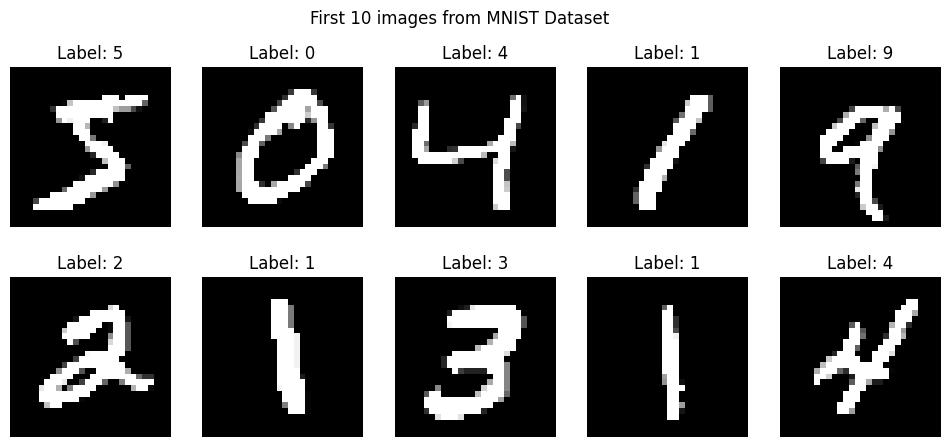

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    image, label = mnist_train[i]
    print(image.shape)
    ax[i // 5, i % 5].imshow(image.permute(1,2,0), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Label: {label}")
    ax[i // 5, i % 5].axis('off')
fig.suptitle("First 10 images from MNIST Dataset")
plt.show()

We see the following warning: *Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).* This is due to our choice of z-score normalization. The imshow function required the data to to be between 0 and 1. To overcome this issue, we will write a function to unnormalize the pixels and replot a few examples below.  

In [ ]:
def unnormalize(img_tensor, mean, std):
    """
    Reverses the Normalize transform.
    """
    tensor = img_tensor.clone()
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    tensor.mul_(std).add_(mean)

    return tensor

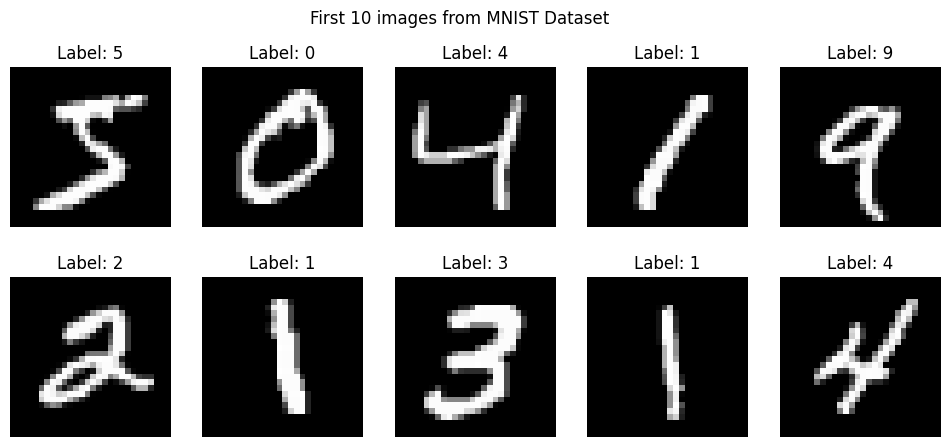

In [ ]:
# Replotting the first 10 images after unnormalization
fig, ax = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    image, label = mnist_train[i]
    image = unnormalize(image, mnist_mean, mnist_std)
    ax[i // 5, i % 5].imshow(image.permute(1,2,0), cmap='gray')
    ax[i // 5, i % 5].set_title(f"Label: {label}")
    ax[i // 5, i % 5].axis('off')
fig.suptitle("First 10 images from MNIST Dataset")
plt.show()

#### 1.2.2 Plotting the first 10 images of MNIST-M

torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])
torch.Size([3, 28, 28])


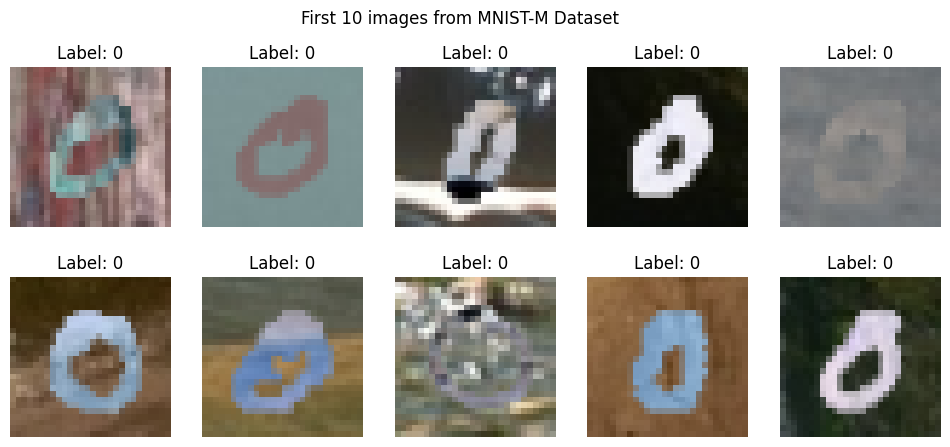

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    image, label = mnistm_train[i]
    image = unnormalize(image, mnistm_mean, mnistm_std)
    print(image.shape)
    ax[i // 5, i % 5].imshow(image.permute(1,2,0))
    ax[i // 5, i % 5].set_title(f"Label: {label}")
    ax[i // 5, i % 5].axis('off')
fig.suptitle("First 10 images from MNIST-M Dataset")
plt.show()

#### 1.2.3 Visualizing random samples from MNIST-M
Our training set is ordered as per the labels and thus we see all the images belonging to 0. We can plot random samples loaded to visualize more diverse labels and their corresponding images.

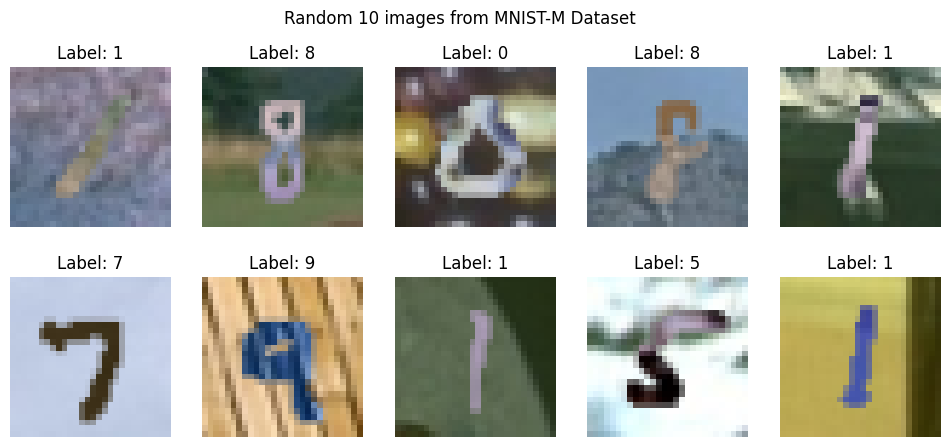

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    mnistm_sample = next(iter(DataLoader(mnistm_train, batch_size=1, shuffle=True)))
    image = unnormalize(mnistm_sample[0][0], mnistm_mean, mnistm_std)
    ax[i // 5, i % 5].imshow(image.permute(1,2,0))
    ax[i // 5, i % 5].set_title(f"Label: {mnistm_sample[1][0]}")
    ax[i // 5, i % 5].axis('off')
fig.suptitle("Random 10 images from MNIST-M Dataset")
plt.show()

### 1.3 Model training: VGG-style CNN

We employ a "Mini-VGG" style CNN architecture. This design uses deeper stacks of small $3 \times 3$ convolutional filters compared to older architectures like LeNet-5, allowing it to learn more complex, non-linear representations necessary for handling the textured backgrounds of the target domain (MNIST-M).

The network structure processes data in the following stages:

#### 1. Feature Extraction Stage
The input image ($3 \times 28 \times 28$) passes through two convolutional blocks. Each block consists of two Convolutional layers, each followed by Batch Normalization and ReLU activation, ending with a $2 \times 2$ Max Pooling layer.

* **Block 1:** Expands depth to 64 channels, reduces size to $14 \times 14$.
* **Block 2:** Expands depth to 128 channels, reduces size to $7 \times 7$.

#### 2. Latent Representation ($Z$)
The output of the feature extractor is a 3D tensor of shape $(128, 7, 7)$. This is **flattened** into a single 1D vector of $6272$ neurons. This represents the latent vector, denoted as **$Z$**.

#### 3. Classification Stage
The latent vector $Z$ is fed into a 3-layer MLP classifier with Dropout ($p=0.5$) applied between the hidden layers to prevent overfitting.

* **Structure:** $6272 \rightarrow 256 \rightarrow 128 \rightarrow \text{Num Classes (10)}$

The model's `forward()` passes returns both the final classification logits and the latent vector $Z$.

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        self.flatten_dim = 128 * 7 * 7

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    # Forward method returns both logits and latent representation
    def forward(self, x):
        z = self.features(x)
        z = z.view(z.size(0), -1)  # Flatten
        out = self.classifier(z)
        return out, z

def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    running_loss = 0.0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

### 1.3.1 Baseline testing

Let us proceed with training this model on MNIST dataset and evaluate the performance on MNIST-M. We will use `AdamW` optimizer with a learning rate of `1e-3`. We minimize the supervised cross-entropy loss between predicted and true labels:

$$
\mathcal{L}_{\text{CE}}(\theta) = -\frac{1}{N_s} \sum_{i=1}^{N_s} \log f_\theta^{(Y_s^{(i)})}(X_s^{(i)}),
$$

where $f_\theta^{(k)}(x)$ denotes the predicted probability for class $k$, and $K = 10$ is the number of classes.

In [9]:
## Training the CNN on MNIST dataset

Baseline_model = CNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Baseline_model.parameters(), lr=LEARNING_RATE)

# Target location for saving models
models_path = "/content/drive/MyDrive/DA_Project/models/"
if not os.path.exists(models_path):
    os.makedirs(models_path)

best_model_file_path = os.path.join(models_path, f"best_cnn_mnist_{BATCH_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}.pth")

# Main Training Loop
print(f"\n Starting training...")
best_val_acc = 0.0
best_model_wts = copy.deepcopy(Baseline_model.state_dict())

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    Baseline_model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in source_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, _ = Baseline_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # End of Epoch Metrics
    epoch_loss = running_loss / len(source_train_loader)
    train_acc = 100 * train_correct / train_total  # Calculate Train Acc
    val_loss, val_acc = evaluate(Baseline_model, source_val_loader, criterion, device)  # Calculate Val loss and Acc

    # Print both for comparison
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Checkpointing based on Validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(Baseline_model.state_dict())

total_time = time.time() - start_time
print(f"\n Training Complete in {total_time:.1f}s. Best Val Acc: {best_val_acc:.2f}%")

# Save the best model weights
torch.save(best_model_wts, best_model_file_path)
print(f"Best model weights saved to {best_model_file_path}")


 Starting training...
Epoch [1/20] | Train Loss: 0.1936 | Val Loss: 0.0507 | Train Acc: 93.84% | Val Acc: 98.42%
Epoch [2/20] | Train Loss: 0.0601 | Val Loss: 0.0655 | Train Acc: 98.21% | Val Acc: 98.00%
Epoch [3/20] | Train Loss: 0.0480 | Val Loss: 0.0480 | Train Acc: 98.59% | Val Acc: 98.58%
Epoch [4/20] | Train Loss: 0.0394 | Val Loss: 0.0370 | Train Acc: 98.78% | Val Acc: 98.97%
Epoch [5/20] | Train Loss: 0.0341 | Val Loss: 0.0466 | Train Acc: 99.03% | Val Acc: 98.93%
Epoch [6/20] | Train Loss: 0.0286 | Val Loss: 0.0308 | Train Acc: 99.14% | Val Acc: 99.18%
Epoch [7/20] | Train Loss: 0.0267 | Val Loss: 0.0435 | Train Acc: 99.19% | Val Acc: 98.82%
Epoch [8/20] | Train Loss: 0.0275 | Val Loss: 0.0365 | Train Acc: 99.23% | Val Acc: 99.12%
Epoch [9/20] | Train Loss: 0.0218 | Val Loss: 0.0344 | Train Acc: 99.30% | Val Acc: 99.18%
Epoch [10/20] | Train Loss: 0.0201 | Val Loss: 0.0318 | Train Acc: 99.38% | Val Acc: 99.20%
Epoch [11/20] | Train Loss: 0.0187 | Val Loss: 0.0330 | Train Acc:

In [11]:
# Load the best model weights for evaluation
loaded_model = CNN(num_classes=NUM_CLASSES).to(device)
loaded_model.load_state_dict(torch.load(best_model_file_path))

# Final Test on Unseen Data
_,test_acc = evaluate(loaded_model, source_test_loader, criterion, device)
print(f" Final Source Test Acc: {test_acc:.2f}%")

# Domain Shift Performance
_,acc_target = evaluate(loaded_model, target_test_loader, criterion, device)
print(f" Target Domain Test Acc: {acc_target:.2f}%")
print(f"\n Performance Drop due to Domain Shift: {test_acc - acc_target:.2f}%")

 Final Source Test Acc: 99.43%
 Target Domain Test Acc: 43.72%

 Performance Drop due to Domain Shift: 55.71%


We observe that our model's performance dropped over 50% on the target domain. This is a clear indication that the model fails to generalize under domain shift. While the MNIST-M dataset appears structurally similar to the source, the network struggles to learn dataset-invariant features due to the noise and color variations. With the problem of covariate shift effectively demonstrated, we will now tackle it using Distance-based and Adversarial Domain Adaptation techniques.